In [19]:
import torch

G = 6.67408e-11

mass1 = float(input("Enter the mass of body 1 (in kg): "))
mass2 = float(input("Enter the mass of body 2 (in kg): "))
m1 = torch.tensor([mass1], requires_grad=False)
m2 = torch.tensor([mass2], requires_grad=False)


x1_initial = float(input("Enter the x-coordinate of body 1: "))
y1_initial = float(input("Enter the y-coordinate of body 1: "))
x2_initial = float(input("Enter the x-coordinate of body 2: "))
y2_initial = float(input("Enter the y-coordinate of body 2: "))
x1_0 = torch.tensor([x1_initial, y1_initial], requires_grad=True)
x2_0 = torch.tensor([x2_initial, y2_initial], requires_grad=True)


vx1_initial = float(input("Enter the x-velocity of body 1: "))
vy1_initial = float(input("Enter the y-velocity of body 1: "))
vx2_initial = float(input("Enter the x-velocity of body 2: "))
vy2_initial = float(input("Enter the y-velocity of body 2: "))
v1_0 = torch.tensor([vx1_initial, vy1_initial], requires_grad=True)
v2_0 = torch.tensor([vx2_initial, vy2_initial], requires_grad=True)

t = float(input("\nEnter the time (in seconds) at which prediction is required: "))
T = torch.tensor([t], requires_grad=True)


Enter the mass of body 1 (in kg): 1
Enter the mass of body 2 (in kg): 2
Enter the x-coordinate of body 1: 1
Enter the y-coordinate of body 1: 1
Enter the x-coordinate of body 2: 2
Enter the y-coordinate of body 2: 3
Enter the x-velocity of body 1: 1
Enter the y-velocity of body 1: 1
Enter the x-velocity of body 2: 2
Enter the y-velocity of body 2: 2

Enter the time (in seconds) at which prediction is required: 1


In [20]:
import numpy as np

n_samples = 100
times = torch.linspace(0, 10, n_samples).view(-1, 1)

def numerical_solver(t, x1_0,x2_0,v1_0, v2_0, m1, m2):
    x1 = x1_0.detach().numpy()
    x2 = x2_0.detach().numpy()
    v1 = v1_0.detach().numpy()
    v2 = v2_0.detach().numpy()
    dt = 0.1
    positions = []

    for _ in t:
        r = x2 - x1
        dist3 = np.linalg.norm(r) ** 3
        a1 = G * m2.item() * r / dist3
        a2 = -G * m1.item() * r / dist3

        v1 += a1 * dt
        v2 += a2 * dt
        x1 += v1 * dt
        x2 += v2 * dt

        positions.append(np.concatenate([x1, x2]))

    return torch.tensor(positions, dtype=torch.float32)

positions = numerical_solver(times, x1_0, x2_0, v1_0, v2_0, m1, m2)


In [24]:
import torch.nn as nn

class PlanetNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 4)
        )

    def forward(self, t):
        return self.net(t)

model = PlanetNet()


In [27]:
# ODE LOSS FUNCTION
def ode_loss(model,t,m1,m2):
 t.requires_grad_(True)
 pred=model(t)
 x1=pred[:,0:2]
 x2=pred[:, 2:4]

 r=x2 - x1
 dist3=(r.norm(dim=1,keepdim=True)**3)
 dx=[]

 for i in range(4):
  grad_i=torch.autograd.grad(pred[:,i],t,grad_outputs=torch.ones_like(pred[:,i]),create_graph=True)[0]
  dx.append(grad_i)
 dx=torch.cat(dx,dim=1)
 d2x=[]

 for i in range(4):
  grad2_i=torch.autograd.grad(dx[:,i],t, grad_outputs=torch.ones_like(dx[:,i]),create_graph=True)[0]
  d2x.append(grad2_i)
 d2x=torch.cat(d2x,dim=1)
 a1_pred=d2x[:,0:2]
 a2_pred=d2x[:,2:4]
 a1_true=G*m2*r/dist3
 a2_true= -G*m1*r/dist3
 return ((a1_pred -a1_true)**2).mean()+((a2_pred-a2_true)**2).mean()


In [28]:
# TRAINING
import torch.optim as optim

optimizer=optim.Adam(model.parameters(),lr=1e-3)
epochs=1000

for epoch in range(epochs):
 model.train()
 optimizer.zero_grad()

 pred=model(times)
 loss_data=nn.MSELoss()(pred,positions)
 loss_physics=ode_loss(model,times,m1,m2)

 loss=loss_data+0.1*loss_physics
 loss.backward()
 optimizer.step()

 if epoch %100==0:
  print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Data Loss: {loss_data.item():.6f}, ODE Loss: {loss_physics.item():.6f}")


Epoch 0, Loss: 116.406891, Data Loss: 116.406281, ODE Loss: 0.006102
Epoch 100, Loss: 28.969120, Data Loss: 28.698736, ODE Loss: 2.703833
Epoch 200, Loss: 11.054822, Data Loss: 10.983084, ODE Loss: 0.717384
Epoch 300, Loss: 4.475693, Data Loss: 4.428189, ODE Loss: 0.475040
Epoch 400, Loss: 2.026126, Data Loss: 1.992225, ODE Loss: 0.339014
Epoch 500, Loss: 1.009583, Data Loss: 0.983505, ODE Loss: 0.260783
Epoch 600, Loss: 0.550669, Data Loss: 0.527448, ODE Loss: 0.232208
Epoch 700, Loss: 0.326713, Data Loss: 0.304598, ODE Loss: 0.221150
Epoch 800, Loss: 0.208745, Data Loss: 0.187211, ODE Loss: 0.215340
Epoch 900, Loss: 0.142308, Data Loss: 0.121332, ODE Loss: 0.209757


In [29]:
# EVALUATION
model.eval()
with torch.no_grad():
    pred_test = model(times)
    mae = torch.mean(torch.abs(pred_test - positions))
    print(f"MAE of predicted trajectory vs ground truth: {mae.item():.6f}")

# Mean ODE Residual
residual = ode_loss(model, times, m1, m2)
print(f"Mean ODE residual: {residual.item():.6f}")


MAE of predicted trajectory vs ground truth: 0.120293
Mean ODE residual: 0.203187


In [30]:
model.eval()
with torch.no_grad():
    # Reshape T to have a batch dimension of 1
    pred_T = model(T.view(1, -1))
    x1_T = pred_T[:, :2]
    x2_T = pred_T[:, 2:]
    print(f"x1(T={T.item()}): {x1_T.detach().numpy()}")
    print(f"x2(T={T.item()}): {x2_T.detach().numpy()}")

x1(T=1.0): [[2.1337376 2.079543 ]]
x2(T=1.0): [[4.215283 5.116272]]


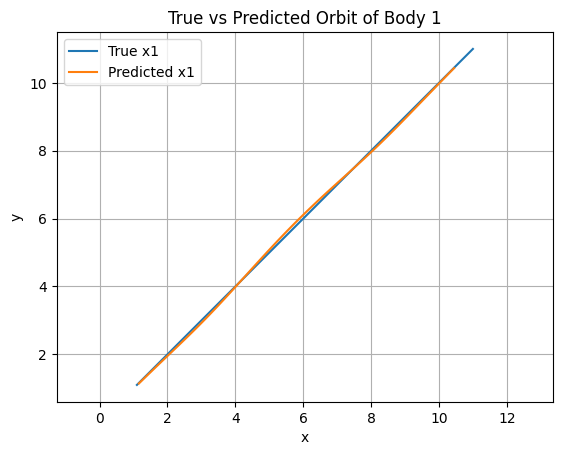

In [31]:
import matplotlib.pyplot as plt

true_x1 = positions[:, :2].numpy()
pred_x1 = model(times).detach().numpy()[:, :2]

plt.plot(true_x1[:, 0], true_x1[:, 1], label='True x1')
plt.plot(pred_x1[:, 0], pred_x1[:, 1], label='Predicted x1')
plt.title("True vs Predicted Orbit of Body 1")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
plt.axis("equal")
plt.show()